### This notebook does the fine-tuning using roberta, the task is regression

In [1]:
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

from transformers import (
    AutoModelForSequenceClassification,
    AdamW,
    get_scheduler,
    AutoConfig,
    AutoTokenizer
)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import sys
import os
from typing import List, Tuple, Optional

# Custom preprocessor import
sys.path.append(str(Path.cwd().parents[1] / "src"))
from preprocessing.preprocess_dataset import RobertaPreprocessor


/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Project Setup

In [2]:
PROJECT_ROOT = Path.cwd().parents[1]
DATA_DIR = Path("/Volumes/MACBACKUP/Regression/final_datasets") # Dataset folder
MODEL_DIR = Path("/Volumes/MACBACKUP/models/roberta-v2-regression") # Folder to save model checkpoints
PLOT_DIR = PROJECT_ROOT / "plots" / "roberta-v2-regression" # Folder to save plots

MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

### Model Config

In [3]:
MODEL_NAME = "roberta-base"
LEARNING_RATE = 2e-5
EPOCHS = 20
BATCH_SIZE = 4
EARLY_STOPPING_PATIENCE = 3

### Dataset Class

In [4]:
class DepressionDataset(Dataset):
    """Custom dataset for regression with RoBERTa."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # Regression -> float label
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

### Evaluation Function

In [5]:
def evaluate_regression(model, dataloader, device, loss_fn):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

             # Get model outputs (logits)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits.squeeze()
            labels = labels.squeeze()

            # Squeeze the model output and labels to be 1D for the loss function
            # (shape from [batch_size, 1] to [batch_size])
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)

    return avg_loss, mse, mae

### Plotting Function

In [6]:
def plot_metrics_regression(history, save_dir):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_dir / 'loss_curve.png')

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['val_mae'], 'g-o', label='Validation MAE')
    plt.title('Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_dir / 'mae_curve.png')

### Device Setup

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple GPU).")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using MPS (Apple GPU).


### Data Preparation

In [8]:
preprocessor = RobertaPreprocessor(model_name=MODEL_NAME)

print("Loading and preprocessing data...")
X_train_df, y_train_df = preprocessor.load_and_preprocess(DATA_DIR / "final_train_dataset.csv")
X_dev_df, y_dev_df = preprocessor.load_and_preprocess(DATA_DIR / "final_dev_dataset.csv")

# Chunking (Sentence Aware)
X_train_chunked, y_train_chunked = preprocessor.chunk_dataframe(
    X_train_df, y_train_df, strategy="sentence_aware", chunk_size=510, overlap=2
)
X_dev_chunked, y_dev_chunked = preprocessor.chunk_dataframe(
    X_dev_df, y_dev_df, strategy="sentence_aware", chunk_size=510, overlap=2
)

# Tokenization
train_encodings = preprocessor.tokenize(X_train_chunked['text'])
dev_encodings = preprocessor.tokenize(X_dev_chunked['text'])

train_labels = y_train_chunked['label'].tolist()
dev_labels = y_dev_chunked['label'].tolist()

train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2109 > 512). Running this sequence through the model will result in indexing errors


Loading and preprocessing data...
Successfully loaded /Volumes/MACBACKUP/Regression/final_datasets/final_train_dataset.csv. Found 107 records.
Text cleaning complete.
Data prepared. X shape: (107, 1), y shape: (107, 1)

Successfully loaded /Volumes/MACBACKUP/Regression/final_datasets/final_dev_dataset.csv. Found 35 records.
Text cleaning complete.
Data prepared. X shape: (35, 1), y shape: (35, 1)

Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 107, Total chunks: 393
Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 35, Total chunks: 140
Tokenizing for RoBERTa with max_length=512...
Tokenizing for RoBERTa with max_length=512...


### Building Regression Model

In [9]:
def build_roberta_regressor(num_labels=1):
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        problem_type="regression",
        hidden_dropout_prob=0.2,
        attention_probs_dropout_prob=0.3,
    )
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    return model, optimizer

In [10]:
model, optimizer = build_roberta_regressor()
model.to(device)

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementatio

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
# Loss for regression
loss_fn = nn.MSELoss()

In [12]:
# Scheduler
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### Training Loop

In [13]:
history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
best_val_loss = float("inf")
patience_counter = 0
start_time = time.time()

In [14]:
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    model.train()
    total_train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True, dynamic_ncols=True)
    
    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Let the model compute its internal MSELoss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        torch.mps.empty_cache()  # avoids MPS memory stall

        if step % 10 == 0:
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    val_loss, val_mse, val_mae = evaluate_regression(model, dev_loader, device, loss_fn)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {val_mse:.4f} | Val MAE: {val_mae:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} -> {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        patience_counter = 0
        model.save_pretrained(MODEL_DIR)
        preprocessor.tokenizer.save_pretrained(MODEL_DIR)
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break


--- Epoch 1/20 ---


Epoch 1: 100%|██████████| 99/99 [34:42<00:00, 21.03s/it, loss=17.6658]


Epoch 1 | Train Loss: 34.4901 | Val Loss (MSE): 53.7286 | Val MAE: 6.0620
Validation loss improved from inf -> 53.7286. Saving model...

--- Epoch 2/20 ---


Epoch 2: 100%|██████████| 99/99 [36:30<00:00, 22.12s/it, loss=17.3979] 


Epoch 2 | Train Loss: 31.2029 | Val Loss (MSE): 50.0615 | Val MAE: 6.0018
Validation loss improved from 53.7286 -> 50.0615. Saving model...

--- Epoch 3/20 ---


Epoch 3: 100%|██████████| 99/99 [32:02<00:00, 19.41s/it, loss=19.8351]  


Epoch 3 | Train Loss: 30.4349 | Val Loss (MSE): 49.0639 | Val MAE: 6.0126
Validation loss improved from 50.0615 -> 49.0639. Saving model...

--- Epoch 4/20 ---


Epoch 4: 100%|██████████| 99/99 [28:04<00:00, 17.02s/it, loss=10.6820]


Epoch 4 | Train Loss: 29.8711 | Val Loss (MSE): 54.7017 | Val MAE: 6.0723
No improvement for 1 epoch(s).

--- Epoch 5/20 ---


Epoch 5: 100%|██████████| 99/99 [30:39<00:00, 18.58s/it, loss=34.6535]


Epoch 5 | Train Loss: 29.6055 | Val Loss (MSE): 50.5465 | Val MAE: 6.0109
No improvement for 2 epoch(s).

--- Epoch 6/20 ---


Epoch 6: 100%|██████████| 99/99 [29:37<00:00, 17.95s/it, loss=20.8338]


Epoch 6 | Train Loss: 29.5033 | Val Loss (MSE): 51.8708 | Val MAE: 6.0347
No improvement for 3 epoch(s).
Early stopping triggered.



Training completed in 192.88 minutes.


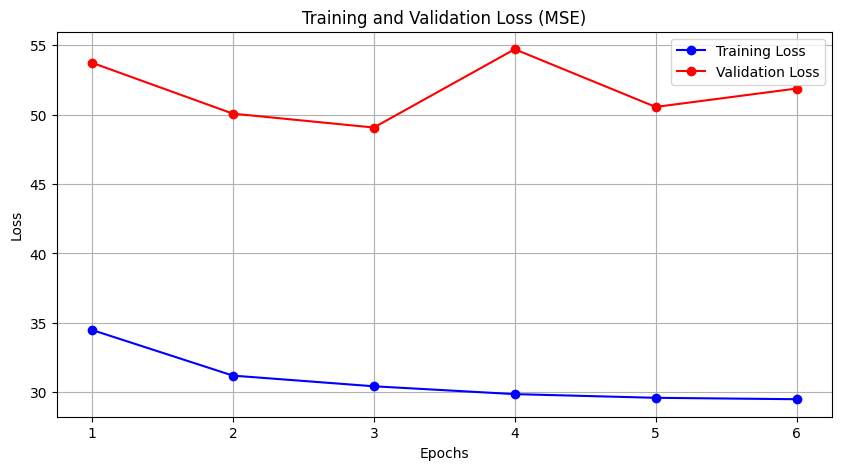

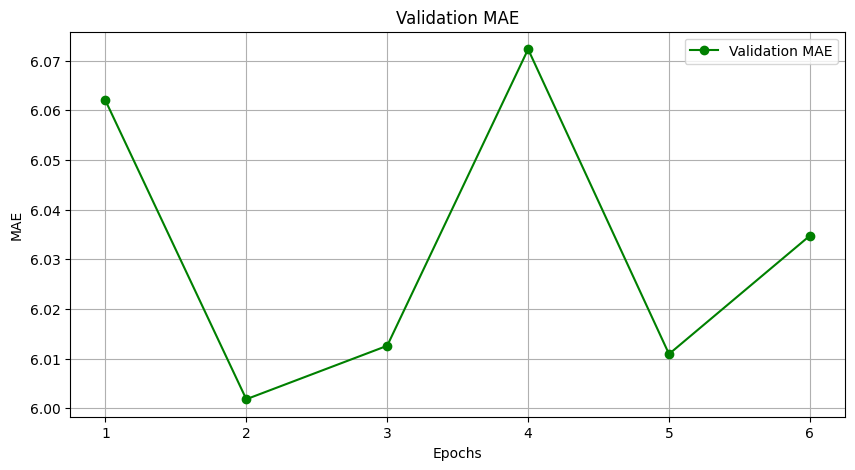

In [15]:
end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")
plot_metrics_regression(history, PLOT_DIR)

In [16]:
# model.train()
# for i, batch in enumerate(train_loader):
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)

#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#     loss = outputs.loss
#     loss.backward()
#     optimizer.step()
#     torch.mps.empty_cache()
#     torch.mps.synchronize()
#     print(f"Batch {i}, loss={loss.item():.4f}")
#     if i == 2:
#         break